### Sommaire



---


- <a href="#C0"> 0. Importation des images </a>
- <a href="#C1"> 1. Data Augmentation </a>
- <a href="#C2"> 2. OPTION -1 : Extraction des features images via VGG16 + classification classique </a>
  - <a href="#C11"> 2.1 Extraction des features via VGG <a>
  - <a href="#C12"> 2.2 Réduction de dimension dans l'espace LDA <a>
  - <a href="#C13"> 2.3 Classification via K-Nearest Neighbor <a>
  - <a href="#C14"> 2.4 Test d'autre modèle de classification et évaluation par validation croisée <a>


- <a href="#C2"> 3. OPTION - 2 : Classification des images par VGG16 avec fine-tuning partiel </a>




In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
import seaborn as sns
import missingno as msno
import clean #mon module de fontions qui me permettent de nettoyer un dataframe
import plot_

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

#---------- NLTK
! pip install --user -U nltk
! pip install word2vec
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
nltk.download('words')
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=143975 sha256=bf5741373e4142e454c271aee6825fac3e60965542bf0d4352ef8db1c77601bd
  Stored in directory: /root/.cache/pip/wheels/6a/fa/d1/e03e8c10e0e2aa5c7b6e2b46b4a1c715d140283853937bb4b1
Successfully built word2vec


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


# <a name="C0"> 0. Importation des images <a>

In [2]:
from os import listdir
!unzip /content/Images.zip -d /content/Images

Archive:  /content/Images.zip
   creating: /content/Images/Images/
  inflating: /content/Images/__MACOSX/._Images  
  inflating: /content/Images/Images/aa68675f50a0551b8dadb954017a50a1.jpg  
  inflating: /content/Images/__MACOSX/Images/._aa68675f50a0551b8dadb954017a50a1.jpg  
  inflating: /content/Images/Images/037c2402fee39fbc80433935711d1383.jpg  
  inflating: /content/Images/__MACOSX/Images/._037c2402fee39fbc80433935711d1383.jpg  
  inflating: /content/Images/Images/42643c1c9403f67921a18654bcf45ead.jpg  
  inflating: /content/Images/__MACOSX/Images/._42643c1c9403f67921a18654bcf45ead.jpg  
  inflating: /content/Images/Images/53f4bc7d7321f5c41de6b86e41f13e80.jpg  
  inflating: /content/Images/__MACOSX/Images/._53f4bc7d7321f5c41de6b86e41f13e80.jpg  
  inflating: /content/Images/Images/b144a363c107c7bdd91f32d6e28ba6f2.jpg  
  inflating: /content/Images/__MACOSX/Images/._b144a363c107c7bdd91f32d6e28ba6f2.jpg  
  inflating: /content/Images/Images/db3e2eeb4fe90d4755f2911d661eae95.jpg  
  in

In [3]:
path = "/content/Images/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [4]:
df = pd.read_csv('/content/flipkart_com-ecommerce_sample_1050.csv')

In [5]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
df['category'] = df['product_category_tree']
for i, it in df['category'].items():
  ls = []
  ls = tokenizer.tokenize(it)
  df['category'].loc[i] = ls[0]

In [6]:
df.groupby("category")['image'].count()

category
Baby         150
Beauty       150
Computers    150
Home         300
Kitchen      150
Watches      150
Name: image, dtype: int64

In [7]:
df_class = df[['image','category']]

In [8]:
df_class

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby


In [9]:
ind_ = df_class.index

# <a name="C1"> 1. Data augmentation <a>

https://albumentations.ai

In [10]:
! pip install albumentations

In [11]:
import cv2
import os
import albumentations as A
from PIL import Image

# Create a pipeline with 4 different transformations.
transform = A.Compose(
    [
    A.OneOrOther(
        A.Compose(
            [
                A.Resize(1024, 1024),
                A.RandomSizedCrop(min_max_height=(256, 512), height=384, width=384, p=0.5),

            ],
        ),
        A.Compose(
            [
                A.ShiftScaleRotate(p=0.5),
                A.GridDistortion(p=.1),

            ]
        ),
    ),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=.5, contrast_limit=.3),
    ])


### Séparation du jeu de donnée

In [12]:
cat = df_class['category'].values

df_train, df_test, cat_train, cat_test, ind_train, ind_test = train_test_split(df_class, cat, ind_, test_size=0.2, random_state=42,
                                                                         stratify = cat)

In [13]:
# Sélection d'un échantillon de 200 images aléatoire au sein du dataset df_train
df_train_aug1 = df_train.sample(200)
df_train_aug2 = df_train[(df_train['category'] == 'Baby')].sample(120)
df_train_aug3 = df_train[(df_train['category'] == 'Home')].sample(120)

In [14]:
def save_im_aug(df):
  #Fonction qui enregistre les images modifié par data augmentation dans le dossier image
  for i in range(len(df)):
    im_name = df['image'].iloc[i]
    im = cv2.imread(path+im_name)
    image = np.array(im)
    # Apply transformation
    transformed = transform(image=image)
    # Access and show transformation
    transformed_image = transformed["image"]
    img = Image.fromarray(transformed_image)
    filename = df['image'].iloc[i]
    img.save('/content/Images/Images/aug_'+str(i)+filename)

In [15]:
save_im_aug(df_train_aug1)
save_im_aug(df_train_aug2)
save_im_aug(df_train_aug3)

In [16]:
path = "/content/Images/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1490


In [17]:
list_photos_aug = [photo for photo in list_photos if photo[:3] == 'aug']
len(list_photos_aug)

440

In [18]:
list_photos_aug

['aug_110b90046b67cafcedfd363afba5fafc1c7.jpg',
 'aug_60984983d05e18e63d1a314e86cb362ae5.jpg',
 'aug_141c7fcd0d983a51283e58b806f065cc920.jpg',
 'aug_1152476ae5a5e045876aa08f5919cb3b91b.jpg',
 'aug_167bb18279e9885136f1dbc8676d4af94e3.jpg',
 'aug_55c109187e7975ee8fdb2b3dfbdd9dce20.jpg',
 'aug_1706fdaa2b03d70da4358311d260456729.jpg',
 'aug_496e812fbc03331ab363789b0f2d6b3ff2.jpg',
 'aug_2810ad262ebfdc8614e847d36e6fe9ecf9.jpg',
 'aug_484e5ebfc871992e7e22365c0c036a1b89.jpg',
 'aug_69e0e261a0d4fd2ffdcbcad324e91a0dd4.jpg',
 'aug_19187f256eeace1a0c2b1f934f061646da5.jpg',
 'aug_81c3c23b5aa5e388e5f71883f61d1a0561.jpg',
 'aug_41873a955df5a2f677a41a7efc94060e41.jpg',
 'aug_131dc777afc918f513a7253187e00a11948.jpg',
 'aug_884451f1b01168b6a085738d0b0f2f02aa.jpg',
 'aug_107285075cfac3036e8d51591dfe5ba24ab.jpg',
 'aug_560dc4d2767fe8424a3263ab141884f83d.jpg',
 'aug_858b7a51c69b47f4714b5f7131077b5d30.jpg',
 'aug_143e426290a8f57e82680275bb91df91ad1.jpg',
 'aug_593dfdf277bccb74532c0387adfed2897d.jpg',
 'aug

In [19]:
df_train = df_train.sort_index()

In [20]:
df_train

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home
5,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Watches
...,...,...
1043,38782cce965307ddcdbedfcb7fa409c3.jpg,Baby
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby


In [21]:
for i, photo in enumerate(list_photos_aug):
  #print(photo)
  df_train.loc[i + 1048 + 1, 'image'] = photo

In [22]:
test = '448f41c6931b5220c2bb34d1cab21cb220.jpg'
test[-36:]

'8f41c6931b5220c2bb34d1cab21cb220.jpg'

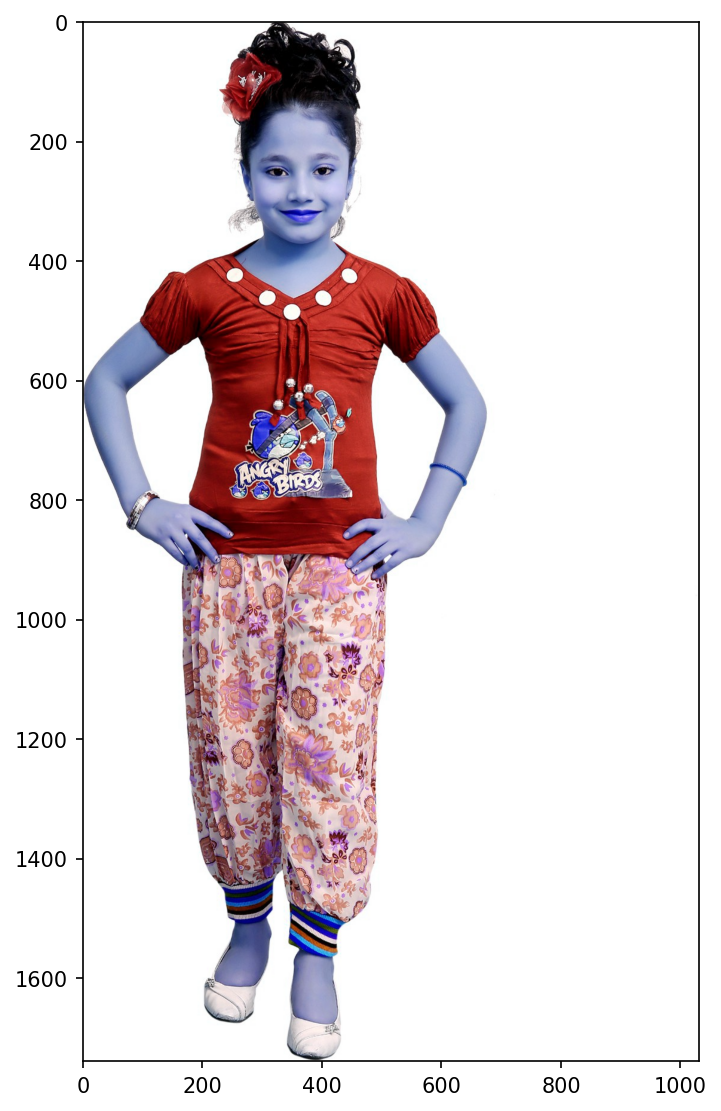

In [23]:
fig, ax = plt.subplots(figsize= (9,9), dpi = 150)
im_test = cv2.imread('/content/Images/Images/8f41c6931b5220c2bb34d1cab21cb220.jpg')
plt.imshow(im_test)

In [24]:
df_train[df_train['image']== test[-36:] ]

,image,category
865,8f41c6931b5220c2bb34d1cab21cb220.jpg,Baby


In [25]:
df_train.loc[1049]

image       aug_110b90046b67cafcedfd363afba5fafc1c7.jpg
category                                            NaN
Name: 1049, dtype: object

In [26]:
df_class[df_class['image'] == 'c3edc504d1b4f0ba6224fa53a43a7ad6.jpg']

,image,category
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby


In [27]:
for i, row in df_train.loc[1048:].iterrows():
  r = str(row['image'])
  filename = r[-36:]
  #print(filename)
  cat = df_train.loc[df_train['image'] == filename, 'category'].values
  #print(cat[0])
  df_train.loc[df_train['image']== r, 'category'] = cat[0]

In [28]:
df_train

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home
5,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Watches
...,...,...
1484,aug_78fd6cbcc22efb6b761bd564c28928483c.jpg,Baby
1485,aug_89b454f9f449c9dff58b90113ba984ea98.jpg,Baby
1486,aug_117a51b2c34b3d5a6e5d0591ee6e0b4d335.jpg,Baby
1487,aug_807ec5ac2dea80b6c5e4cfd20eba597d20.jpg,Home


In [29]:
#Dataframe qui me permettra de comparer les performances des différents modèles
df_analyse = df_test[['image', 'category']]
df_analyse

,image,category
647,3dfd14b667357e26ff6d66761cdc203f.jpg,Baby
342,17a73d7c4b02ada2bfeed1115fed08a4.jpg,Beauty
752,83cef279f0ea5d772523d0d8b2923fbe.jpg,Home
56,24e85c590481a7cedfe66597f253f2b2.jpg,Beauty
386,59d964c38c787f829c6cfa5629e4df90.jpg,Beauty
...,...,...
258,9833d0de7f7e1927c807411c10b19189.jpg,Home
201,9c4ab8ab059c912090c83cb0818e7f1c.jpg,Home
672,6eabdbbbffdfae86c3c5177ba0f96ea7.jpg,Baby
809,1d1be744e491ed61e705c20e4a72320d.jpg,Beauty


# <a name="C2"> 2. OPTION -1 : Extraction des features images via VGG16 + classification classique <a>

### Stratégie 1  : extraction des features puis entraînement du KNN Classifier


---
**Partie 1**

1.   On récupère le modèle VGG16 pré-entraîné sur 15 millions d'images.
2.   On limite l'utilisation du VGG à l'extraction de feature en désactivant la dernière couche fully-connected.
3.   J'importe les images au format 224x224 et je les mets sous forme vectoriel 224x224x3
4.   J'utilise un .predict sur mes images pour obtenir les features en me basant sur le jeu d'entraînement propre au VGG16.

5. Je sépare mes données en set d'entraînement et en set de test.

5. Création d'un pipeline :
    * Standardisation
    * Réduction de dimension via Linear Discriminant Analysis
    * KNN Classifier.
6. Test du modèle sur mon jeu test.
7. Evaluation du modèle par validation croisée, puis test.
8. Analyse par classes



In [30]:
base_model = VGG16() #on instancie le modèle de base sans paramètre particulier
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

## <a name="C21"> 2.1 Extraction des features via VGG <a>

- ### Extraction des features des images

In [31]:
def feature_image(df):
  images_features = []
  i=0
  for image_file in df["image"]: #.loc[ind_sample] : #Échantillon de 300 images
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(path+image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model
  images_features = np.asarray(images_features)
  images_features.shape
  return images_features

In [86]:
X_train = feature_image(df_train)
X_test = feature_image(df_test)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
0
100
200


## <a name="C22"> 2.2 Réduction de dimension dans l'espace LDA <a>

In [87]:
y_train = df_train['category']
y_test = df_test['category']

In [88]:
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.transform(X_test)

In [89]:
df_train

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home
5,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Watches
...,...,...
1484,aug_78fd6cbcc22efb6b761bd564c28928483c.jpg,Baby
1485,aug_89b454f9f449c9dff58b90113ba984ea98.jpg,Baby
1486,aug_117a51b2c34b3d5a6e5d0591ee6e0b4d335.jpg,Baby
1487,aug_807ec5ac2dea80b6c5e4cfd20eba597d20.jpg,Home


### Vérification de la répartition



<Axes: xlabel='count', ylabel='category'>

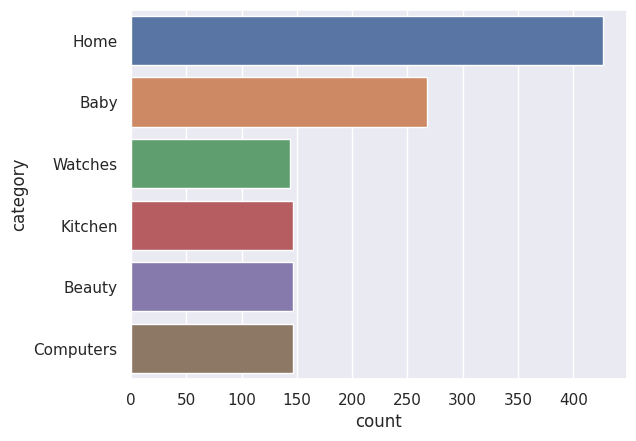

In [90]:
sns.set()
sns.countplot(data = df_train, y = 'category')

<Axes: xlabel='count', ylabel='category'>

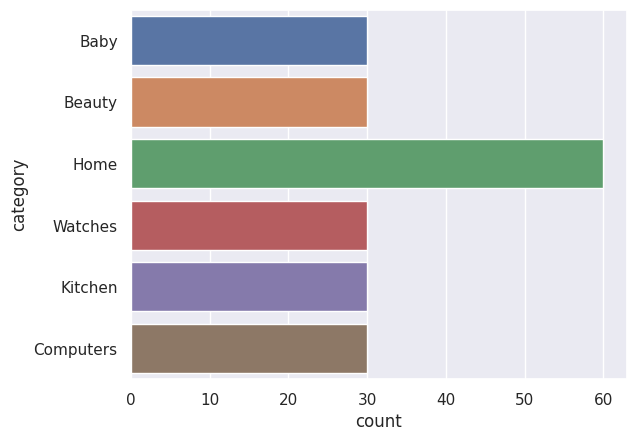

In [91]:
sns.set()
sns.countplot(data = df_test, y = 'category')

### Réduction de dimension

In [92]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=5, solver='eigen', shrinkage=0.1)
X_r2_train = lda.fit(X_train_scaled, y_train).transform(X_train_scaled)

In [93]:
ind_train = df_train.index
X_r2_test = lda.transform(X_test_scaled)
X_r2_tot = np.concatenate((X_r2_train, X_r2_test), axis=0)
df_lda = pd.DataFrame(X_r2_tot, columns=['Dim1', 'Dim2','Dim3','Dim4','Dim5'])
size_train = len(df_train)

#category
df_lda['category'] = ''
df_lda['category'].iloc[:size_train] = y_train
df_lda['category'].iloc[size_train:] = y_test
#reférence image
df_lda['image'] = ''
df_lda['image'].iloc[:size_train] = df_train['image']
df_lda['image'].iloc[size_train:] = df_test['image']
#index de df_class
df_lda['index'] = ''
df_lda['index'].iloc[:size_train] = df_train.index
df_lda['index'].iloc[size_train:] = df_test.index


In [94]:
len(X_r2_train)

1280

In [95]:
y_test

647      Baby
342    Beauty
752      Home
56     Beauty
386    Beauty
        ...  
258      Home
201      Home
672      Baby
809    Beauty
783      Baby
Name: category, Length: 210, dtype: object

In [96]:
df_lda

,Dim1,Dim2,Dim3,Dim4,Dim5,category,image,index
0,3.906468,4.146708,0.609852,0.270356,-5.116421,Home,55b85ea15a1536d46b7190ad6fff8ce7.jpg,0
1,4.231882,4.004754,2.611166,-0.619882,6.403298,Baby,7b72c92c2f6c40268628ec5f14c6d590.jpg,1
2,3.709944,3.633699,0.773511,0.559534,-4.947058,Home,d4684dcdc759dd9cdf41504698d737d8.jpg,3
3,3.926080,3.656360,1.418931,0.728977,-5.388001,Home,6325b6870c54cd47be6ebfbffa620ec7.jpg,4
4,-22.240547,2.302013,0.559240,-1.059100,0.552729,Watches,893aa5ed55f7cff2eccea7758d7a86bd.jpg,5
...,...,...,...,...,...,...,...,...
1485,-4.480209,-2.783432,-1.344927,4.769898,-0.770818,Home,9833d0de7f7e1927c807411c10b19189.jpg,258
1486,-0.271457,1.747084,-1.159365,-3.918077,-6.654056,Home,9c4ab8ab059c912090c83cb0818e7f1c.jpg,201
1487,2.811830,4.809329,-5.602209,-2.285490,-1.541566,Baby,6eabdbbbffdfae86c3c5177ba0f96ea7.jpg,672
1488,1.430919,-6.143677,-15.441139,-9.776971,-1.415047,Beauty,1d1be744e491ed61e705c20e4a72320d.jpg,809


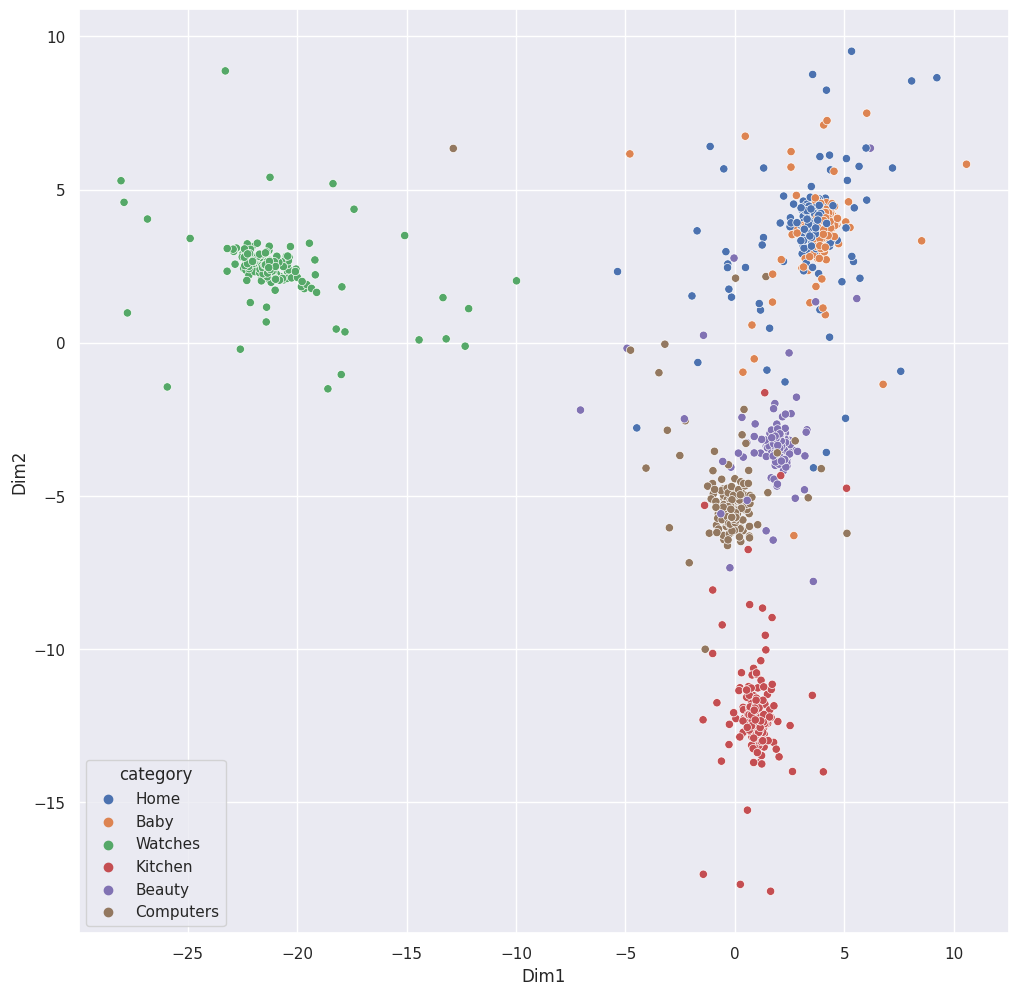

In [97]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data= df_lda, x='Dim1', y='Dim2',hue = 'category')
plt.savefig('/content/Fichier_N3/P6_N3_22_LDA_aug.png')
plt.show()

## <a name="C23"> 2.3 Classification via K-nearest neighbor <a>

### Baseline de classification

In [98]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_r2_train,y_train)
y_pred = dummy_clf.predict(X_r2_test)
error_rate = np.mean(y_pred != y_test)
print(error_rate)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

0.861904761904762
              precision    recall  f1-score   support

        Baby       0.12      0.13      0.13        30
      Beauty       0.06      0.07      0.06        30
   Computers       0.16      0.20      0.18        30
        Home       0.22      0.17      0.19        60
     Kitchen       0.10      0.10      0.10        30
     Watches       0.14      0.13      0.14        30

    accuracy                           0.14       210
   macro avg       0.13      0.13      0.13       210
weighted avg       0.14      0.14      0.14       210



In [99]:
cf = confusion_matrix(y_test, y_pred)
cf

array([[ 4,  8,  8,  4,  4,  2],
       [ 3,  2,  8,  6,  5,  6],
       [ 5,  5,  6,  8,  2,  4],
       [11, 12,  7, 10, 10, 10],
       [ 6,  5,  3, 10,  3,  3],
       [ 4,  3,  6,  8,  5,  4]])

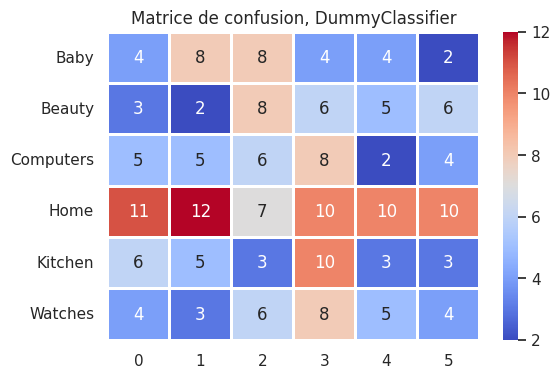

In [100]:
df_cm = pd.DataFrame(cf, index = [label for label in ['Baby', 'Beauty', 'Computers', 'Home', 'Kitchen', 'Watches']],
                  columns = [i for i in "012345"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm,cmap='coolwarm', annot=True, linewidth=1)
plt.title('Matrice de confusion, DummyClassifier')
plt.savefig('/content/Fichier_N3/P6_N3_23_dummy.png')




### Recherche de la valeur optimale de *k*

Minimum error: 0.18095238095238095 at K = 1


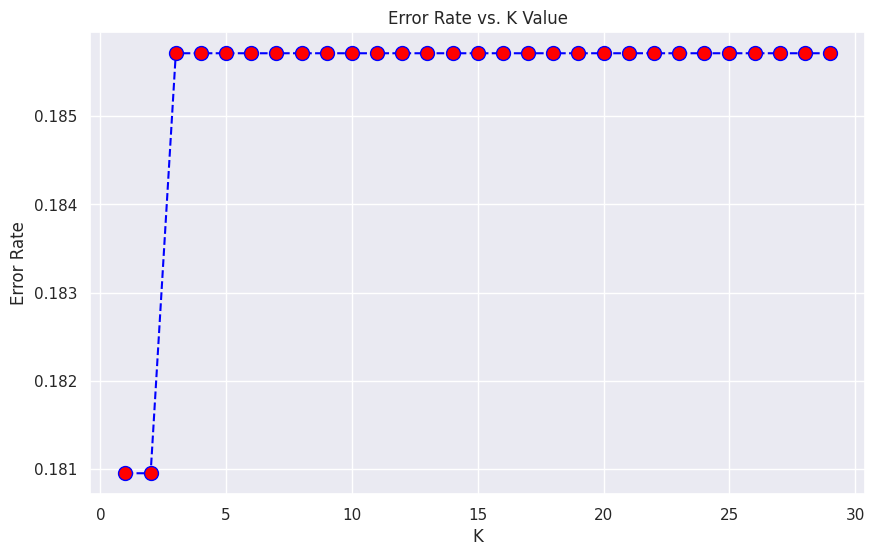

In [101]:
from sklearn.neighbors import KNeighborsClassifier
error_rate = []
## Recherche de la valeur optimale de k
for k in range(1,30):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_r2_train,y_train)
  pred_i = neigh.predict(X_r2_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rate,color='blue', linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

je choisie de garder la valeur de :


```
k = error_rate.index(min(error_rate))+1

```



## <a name="C24"> 2.4 Test d'autre modèle de classification et évaluation par validation croisée <a>



---


Test : Je teste trois modèles de prédictions :


*   KNN
*   LDA
*   SVC

L'opérateur LDA (Linear Discriminant Analysis) est à la fois un moyen de réduction de dimension, de classification. J'aimerais comparer les performances des deux modèles.


### Création d'un pipeline

In [117]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

mod = 'svc' #'lda', 'svc', 'knn'

k = error_rate.index(min(error_rate))+1

if mod == 'knn':
  Class_pipe = Pipeline([('scaler', StandardScaler()),
                           ('LDA', LinearDiscriminantAnalysis(n_components=5, solver='eigen', shrinkage=0.1)),
                           ('KNN', KNeighborsClassifier(n_neighbors=k))])

  score = cross_val_score(Class_pipe, X_train, y_train, cv=6)
  score_moy = np.mean(score)
elif mod == 'lda':
  Class_pipe= Pipeline([('scaler', StandardScaler()),
                           ('LDA', LinearDiscriminantAnalysis(n_components=5, solver='eigen', shrinkage=0.1))])

  score = cross_val_score(Class_pipe, X_train, y_train, cv=6)
  score_moy = np.mean(score)
elif mod == 'svc':
  Class_pipe = Pipeline([('scaler', StandardScaler()),
                           ('LDA', LinearDiscriminantAnalysis(n_components=5, solver='eigen', shrinkage=0.1)),
                           ('SVC', SVC(kernel = 'linear'))])

  score = cross_val_score(Class_pipe, X_train, y_train, cv=6)
  score_moy = np.mean(score)

In [118]:
print('Le score moyen d\'accuracy issu de la validation croisée est', score_moy)

Le score moyen d'accuracy issu de la validation croisée est 0.795196934462434


In [119]:
Class_pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LDA',
                 LinearDiscriminantAnalysis(n_components=5, shrinkage=0.1,
                                            solver='eigen')),
                ('SVC', SVC(kernel='linear'))])

In [120]:
if mod == 'lda':
  y_pred_lda = Class_pipe.predict(X_test)
  print(classification_report(y_test, y_pred_lda))
  df_analyse['LDA'] = y_pred_lda
  cf = confusion_matrix(y_test, y_pred_lda)
elif mod == 'knn':
  y_pred_knn = Class_pipe.predict(X_test)
  print(classification_report(y_test, y_pred_knn))
  df_analyse['KNN'] = y_pred_knn
  cf = confusion_matrix(y_test, y_pred_knn)
elif mod == 'svc':
  y_pred_svc = Class_pipe.predict(X_test)
  print(classification_report(y_test, y_pred_svc))
  df_analyse['SVC'] = y_pred_svc
  cf = confusion_matrix(y_test, y_pred_svc)

              precision    recall  f1-score   support

        Baby       0.65      0.57      0.61        30
      Beauty       0.95      0.70      0.81        30
   Computers       0.84      0.87      0.85        30
        Home       0.72      0.82      0.77        60
     Kitchen       0.91      0.97      0.94        30
     Watches       0.97      1.00      0.98        30

    accuracy                           0.82       210
   macro avg       0.84      0.82      0.83       210
weighted avg       0.82      0.82      0.82       210



In [121]:
cf

array([[17,  0,  0, 12,  1,  0],
       [ 0, 21,  3,  4,  2,  0],
       [ 0,  0, 26,  3,  0,  1],
       [ 8,  1,  2, 49,  0,  0],
       [ 1,  0,  0,  0, 29,  0],
       [ 0,  0,  0,  0,  0, 30]])

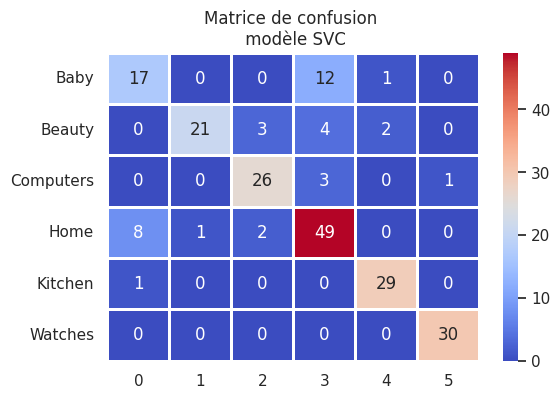

In [122]:
df_cm = pd.DataFrame(cf, index = [label for label in ['Baby', 'Beauty', 'Computers', 'Home', 'Kitchen', 'Watches']],
                  columns = [i for i in "012345"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm,cmap='coolwarm', annot=True, linewidth=1)
plt.title('Matrice de confusion \n modèle '+str(mod).upper())
plt.savefig('/content/Fichier_N3/P6_N3_14_'+str(mod)+'.png',  bbox_inches = 'tight')

# <a name="C2"> 3. Classification des images par VGG16 (jeu d'entraînement VGG16 + data flipkart) - startégie 2 <a>

### Stratégie 2 : Entraînement des couches hautes du réseau avec le jeu d'entaînement + entrâinement d'une couche de prédiction


---

1.   On récupère le modèle VGG16 pré-entraîné sur 15 millions d'images.
2.   On désactive la dernière couche fully-connected.
3.   J'importe les images au format 224x224 et je les mets sous forme vectoriel 224x224x3
5. Je sépare mes données en set d'entraînement et en set de test.
4. Je précise les couches fixes et les couches à entraîner à nouveau avec mon jeu d'entraînement.
5. J'ajoute une couche de prédiction
4. J'entrâine le modèle

6. Test du modèle sur mon jeu test.




---

Je choisis d'échantillonner mon modèle car l'entraînement du VGG :



*   Environ 20h de calcul pour 50 epoch, pour le réentraînement des couches du VGG16 excepté les 5 premières, pour un dataset de 1000 photos.





In [54]:
df_train['image'][600]

'20a06aad5f04727dd54bf13dd5923518.jpg'

In [55]:
ind_train

Int64Index([   0,    1,    3,    4,    5,    6,    7,    9,   11,   12,
            ...
            1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488],
           dtype='int64', length=1280)

- ### Préparation de la collection d'image

In [56]:
def image_prep_fct(data, ind_) :
  i=0
  prepared_images = []
  for image_num in ind_ :
      #print(image_num)
      if i%100 == 0 : print(i)
      i +=1
      #print(i)
      img = (load_img(
            path+data['image'][image_num],
            target_size=(224, 224)))
      #print(path)
      img = img_to_array(img)
      img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
      img = preprocess_input(img)
      prepared_images.append(img)
      prepared_images_np = np.array(prepared_images)
  return prepared_images_np

In [57]:
X_train = image_prep_fct(df_train, ind_train)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


In [58]:
X_test = image_prep_fct(df_test, ind_test)

0
100
200


In [59]:
#Vérification
print(X_train.shape)
print(X_test.shape)

(1280, 224, 224, 3)
(210, 224, 224, 3)


In [60]:
#----------------------------------- Label Encoder ----------------------------------------
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
ls_cat = df_train['category'].unique().tolist()
le.fit(ls_cat)


y_train = le.transform(y_train)
y_test = le.transform(y_test)

- ### Construction du modèle

In [61]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers[:]: #modèle 2 : aucune couche entraînable #modèle trois : 10 dertnières couches entraînables
    #modele 4 : les 5 premières couches fixes
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x) #GlobalMax Pooling
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(6, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="sparse_categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model


In [62]:
with tf.device('/gpu:0'):
  model_2 = create_model_fct()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [63]:
# Création du callback
model_2_save_path = "content/model_2_best_weights.h5"
checkpoint = ModelCheckpoint(model_2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [64]:
X_train_v, X_val, y_train_v, y_val, ind_train_v, ind_val = train_test_split(X_train, y_train, ind_train, test_size=0.2, random_state=42,
                                                                         stratify = y_train)

- ### Entraînement

In [65]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history_model_2 = model_2.fit(X_train_v, y_train_v, epochs=50, batch_size=64, #essai avec epochs = 50
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

#20 min temps d'entraînement en entraînant que le classifieur.
# 32 min en entraînant les

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 4.7344 - accuracy: 0.4639 
Epoch 1: val_loss improved from inf to 1.03061, saving model to content/model_2_best_weights.h5
16/16 [==============================] - 837s 53s/step - loss: 4.7344 - accuracy: 0.4639 - val_loss: 1.0306 - val_accuracy: 0.7461
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 1.6144 - accuracy: 0.6807 
Epoch 2: val_loss improved from 1.03061 to 0.99698, saving model to content/model_2_best_weights.h5
16/16 [==============================] - 822s 52s/step - loss: 1.6144 - accuracy: 0.6807 - val_loss: 0.9970 - val_accuracy: 0.7812
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 1.0726 - accuracy: 0.7451 
Epoch 3: val_loss improved from 0.99698 to 0.82183, saving model to content/model_2_best_weights.h5
16/16 [==============================] - 823s 52s/step - loss: 1.0726 - accuracy: 0.7451 - val_loss: 0.8218 - val_accuracy: 0.7812
Epoch 4/50
16/16 [========

In [66]:
! pip install plot-keras-history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9457 sha256=f906ef16e619c758a613405352fc01f1af1282fa4d0baa3803163a51d827e46f
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320501 sha256=8b1d142b3ddfcf2ba3c9cbd9009d791040d44bd5557fae8ca3364cc0f1a96fc5
  Stored in directory: /root/.cache/pip/wheels/b7/f3/5d/748143833c99806921d4e1182c248876b83464746ef1e46f1d
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=c935b3f75ffd0439f801057e11fd516576ed66ebb1ba2a89bbcf408ff0905dcb
  Stored in director

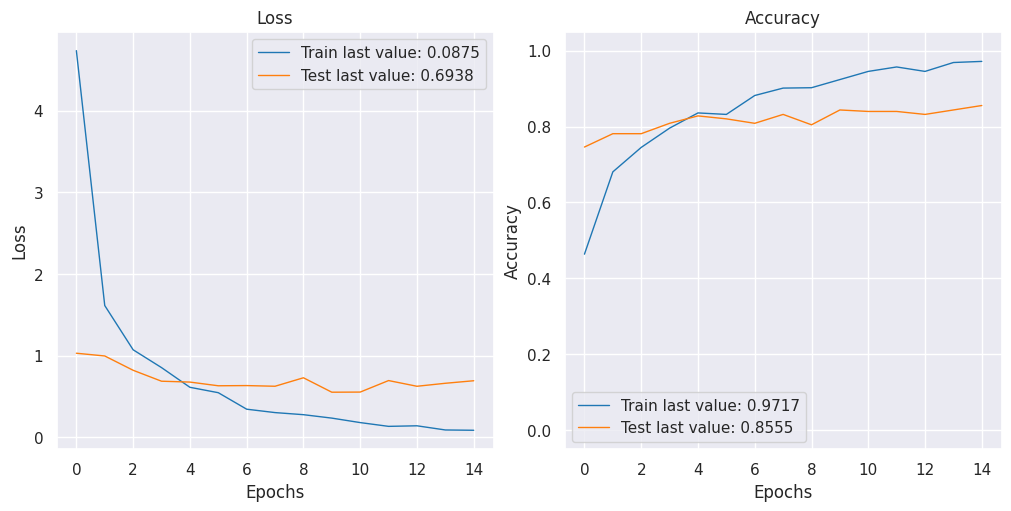

In [67]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history_model_2)
plot_history(history_model_2, path="standard.png")
plt.close()

In [75]:
y_pred = np.argmax(model_2.predict(X_test), axis = 1)

7/7 [==============================] - 135s 18s/step


In [76]:
y_pred

array([0, 1, 3, 5, 1, 5, 0, 3, 3, 0, 0, 4, 2, 5, 4, 4, 3, 3, 0, 3, 2, 2,
       0, 0, 5, 2, 3, 5, 1, 4, 3, 3, 0, 5, 3, 5, 2, 0, 0, 2, 3, 3, 5, 3,
       3, 5, 1, 0, 5, 5, 3, 4, 3, 4, 3, 3, 4, 3, 5, 2, 0, 0, 2, 0, 5, 3,
       2, 4, 4, 5, 3, 1, 0, 4, 4, 3, 3, 1, 2, 1, 3, 4, 3, 5, 3, 0, 3, 0,
       2, 3, 2, 3, 2, 1, 5, 2, 4, 3, 3, 3, 0, 2, 3, 3, 5, 1, 4, 1, 5, 1,
       3, 3, 4, 3, 1, 3, 4, 1, 4, 3, 2, 5, 3, 1, 5, 2, 3, 1, 3, 0, 5, 1,
       1, 5, 4, 3, 3, 4, 2, 5, 5, 3, 3, 3, 5, 1, 1, 3, 3, 3, 3, 4, 0, 2,
       2, 4, 5, 3, 3, 0, 3, 3, 2, 4, 3, 3, 5, 3, 0, 3, 1, 2, 4, 1, 3, 4,
       0, 3, 3, 0, 2, 3, 3, 5, 3, 2, 5, 3, 3, 1, 3, 1, 4, 2, 3, 0, 3, 2,
       4, 0, 1, 2, 0, 0, 0, 2, 3, 3, 1, 0])

In [79]:
y_pred = le.inverse_transform(y_pred)

- ### Résultat

In [80]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[20  0  0  9  1  0]
 [ 0 23  3  3  0  1]
 [ 0  0 23  6  0  1]
 [ 8  1  1 49  1  0]
 [ 2  0  0  4 24  0]
 [ 0  1  1  1  0 27]]


In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Baby       0.67      0.67      0.67        30
      Beauty       0.92      0.77      0.84        30
   Computers       0.82      0.77      0.79        30
        Home       0.68      0.82      0.74        60
     Kitchen       0.92      0.80      0.86        30
     Watches       0.93      0.90      0.92        30

    accuracy                           0.79       210
   macro avg       0.82      0.79      0.80       210
weighted avg       0.80      0.79      0.79       210



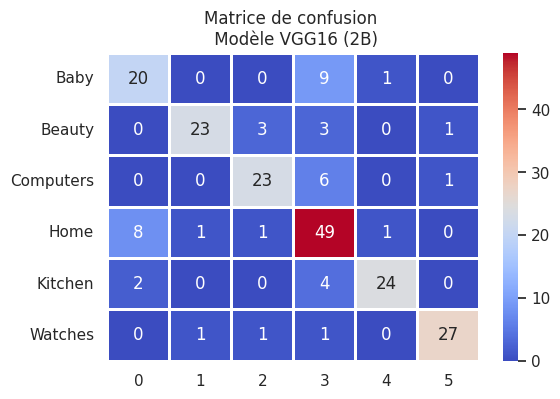

In [82]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in ['Baby', 'Beauty', 'Computers', 'Home', 'Kitchen', 'Watches']],
                  columns = [i for i in "012345"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm,cmap='coolwarm', annot=True, linewidth=1)
plt.title('Matrice de confusion \n Modèle VGG16 (2B)')
plt.savefig('/content/Fichier_N3/P6_N3_heatmap_confusion_modèle2_MAJ.png', bbox_inches = 'tight')